In [10]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer,providers
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution, NormalDistribution
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm_simulator = Aer.get_backend('qasm_simulator')
stv_simulator = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

## Finding Expectations using QAE

In [58]:
## defining distributions ~
num_qubits = 4

## distribution: [normal/ log-normal ]
d_nrml = NormalDistribution(num_qubits, mu = 0, sigma= 1 )

d_nrml.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘

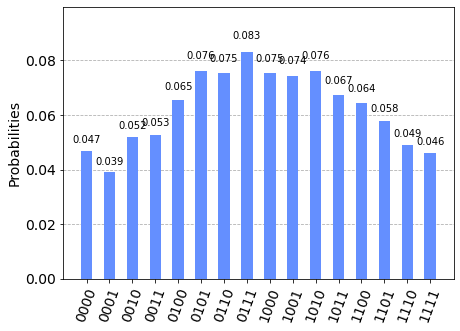

In [54]:
d_nrml.measure_all()
job = execute(d_nrml, backend= aer)
plot_histogram(job.result().get_counts(),sort= 'asc')

In [68]:
## defining a arbitrary linear function 
lae = LinearAmplitudeFunction(num_qubits, 1, -1.0, (0,1),(-1,1), name= 'lae_1' )
lae.draw()

┌────────┐
q2016_0: ┤0       ├
         │        │
q2016_1: ┤1       ├
         │        │
q2016_2: ┤2 lae_1 ├
         │        │
q2016_3: ┤3       ├
         │        │
  q2017: ┤4       ├
         └────────┘

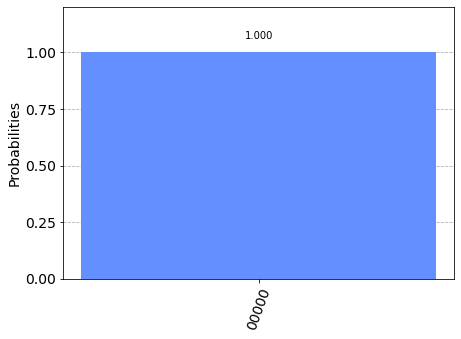

In [69]:
lae.measure_all()
job = execute(lae, backend= aer)
plot_histogram(job.result().get_counts(),sort= 'asc')

In [70]:
qc = lae.compose(d_nrml, qubits= [0,1,2,3] ,front= True)
qc.draw()

┌───────┐┌────────┐ ░ ┌─┐            
q2016_0: ┤0      ├┤0       ├─░─┤M├────────────
         │       ││        │ ░ └╥┘┌─┐         
q2016_1: ┤1      ├┤1       ├─░──╫─┤M├─────────
         │  P(X) ││        │ ░  ║ └╥┘┌─┐      
q2016_2: ┤2      ├┤2 lae_1 ├─░──╫──╫─┤M├──────
         │       ││        │ ░  ║  ║ └╥┘┌─┐   
q2016_3: ┤3      ├┤3       ├─░──╫──╫──╫─┤M├───
         └───────┘│        │ ░  ║  ║  ║ └╥┘┌─┐
  q2017: ─────────┤4       ├─░──╫──╫──╫──╫─┤M├
                  └────────┘ ░  ║  ║  ║  ║ └╥┘
 meas: 5/═══════════════════════╩══╩══╩══╩══╩═
                                0  1  2  3  4

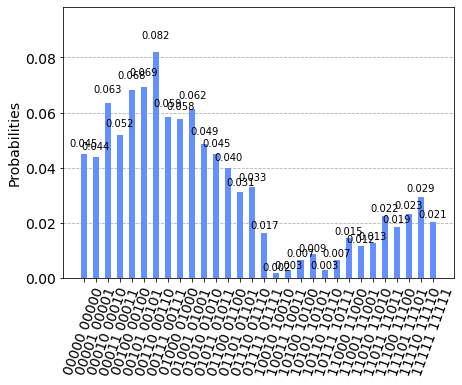

In [71]:
qc.measure([0,1,2,3])
job = execute(qc, backend= aer)
plot_histogram(job.result().get_counts(),sort= 'asc')

## European Put Options

In [46]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)
uncertainty_model.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1 P(X) ├
     │       │
q_2: ┤2      ├
     └───────┘

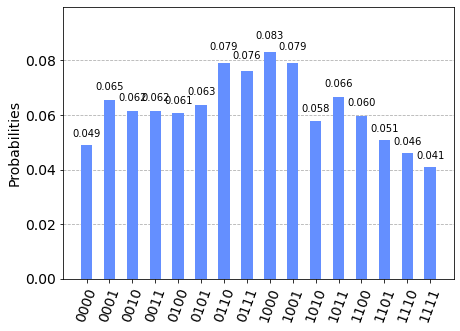

In [35]:
uncertainty_model.measure_all()
job = execute(d_nrml, backend= aer)
plot_histogram(job.result().get_counts(),sort= 'asc')

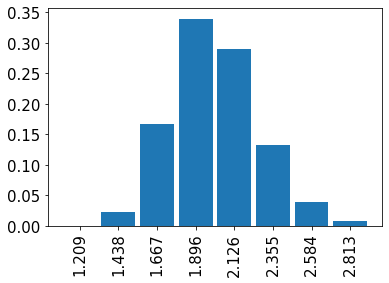

In [73]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()


In [47]:
## amplitue function ~ 
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2.126

# set the approximation scaling for the payoff function
rescaling_factor = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [-1, 0]
offsets = [strike_price - low, 0]
f_min = 0
f_max = strike_price - low
european_put_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=rescaling_factor,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
european_put = european_put_objective.compose(uncertainty_model, front=True)

In [48]:
european_put_objective.draw()

┌────┐
q1830_0: ┤0   ├
         │    │
q1830_1: ┤1   ├
         │    │
q1830_2: ┤2   ├
         │    │
  q1831: ┤3 F ├
         │    │
   a2_0: ┤4   ├
         │    │
   a2_1: ┤5   ├
         │    │
   a2_2: ┤6   ├
         └────┘

In [32]:
european_put.decompose().draw()

»
q1713_0: ───────────────────────────────────────────────────»
                                  ┌────────────────────────┐»
q1713_1: ─────────────────────────┤0                       ├»
         ┌───────────────────────┐│  multiplex2_reverse_dg │»
q1713_2: ┤ multiplex1_reverse_dg ├┤1                       ├»
         └───────────────────────┘└────────────────────────┘»
  q1714: ───────────────────────────────────────────────────»
                                                            »
   a0_0: ───────────────────────────────────────────────────»
                                                            »
   a0_1: ───────────────────────────────────────────────────»
                                                            »
   a0_2: ───────────────────────────────────────────────────»
                                                            »
«         ┌────────────────────────┐┌────┐
«q1713_0: ┤0                       ├┤0   ├
«         │                        ││    │
«q1713_1: ┤1 multiplex3_reverse_dg ├┤1   ├
«         │                        ││    │
«q1713_2: ┤2                       ├┤2   ├
«         └────────────────────────┘│    │
«  q1714: ──────────────────────────┤3 F ├
«                                   │    │
«   a0_0: ──────────────────────────┤4   ├
«                                   │    │
«   a0_1: ──────────────────────────┤5   ├
«                                   │    │
«   a0_2: ──────────────────────────┤6   ├
«                                   └────┘

In [38]:
european_put.measure_all()
job = execute(d_nrml, backend= aer)
plot_histogram(job.result().get_counts())

VisualizationError: 'Must define target_string when using distance measure.'